# The Grange, Edinburgh, Scotland

In [1]:
import warnings
import importlib
warnings.filterwarnings("ignore")

from libs.tools import *
from libs.graph_route import plot_graph_route

import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt

from network import Network
from network.algorithms import hierholzer
ox.config(use_cache=True, log_console=True)
import geopy.distance


In [2]:
CUSTOM_FILTER = (
    '["highway"]["area"!~"yes"]["highway"!~"bridleway|bus_guideway|bus_stop|construction|cycleway|elevator|footway|'
    'motorway|motorway_junction|motorway_link|escalator|proposed|construction|platform|raceway|rest_area|'
    'path|service"]["access"!~"customers|no|private"]["public_transport"!~"platform"]'
    '["fee"!~"yes"]["foot"!~"no"]["service"!~"drive-through|driveway|parking_aisle"]["toll"!~"yes"]'
)

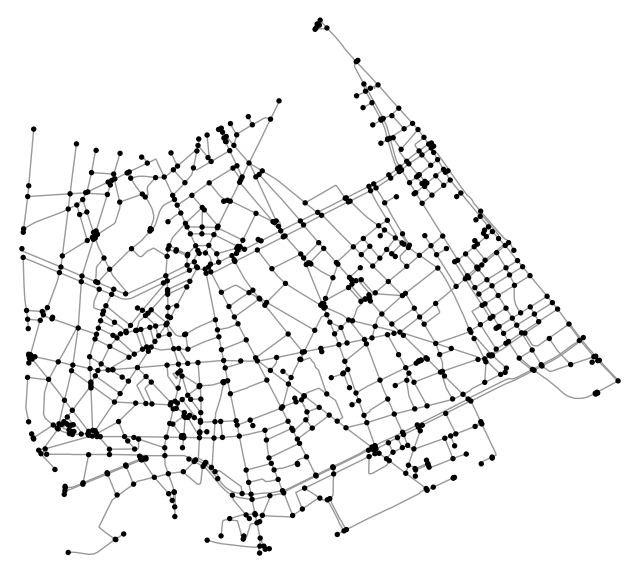

In [3]:
location = "Paris 13e Arrondissement"
org_graph = ox.graph_from_place(location, custom_filter=CUSTOM_FILTER, clean_periphery=False)

# Simplifying the original directed multi-graph to undirected, so we can go both ways in one way streets
graph = ox.utils_graph.get_undirected(org_graph)
fig, ax = ox.plot_graph(graph, node_zorder=2, node_color="k", bgcolor="w")

In [4]:
import json
matched_edges_with_weights = []
try:
    with open('data/' + location + '_matched_edges.json', 'r') as filehandle:
        matched_edges_with_weights = json.load(filehandle)
    print("Loaded matched edges from file")
except:
    # Finds the odd degree nodes and minimal matching
    odd_degree_nodes = get_odd_degree_nodes(graph)
    print("start pair weights")
    pair_weights = get_shortest_distance_for_odd_degrees(graph, odd_degree_nodes)
    print("start min matching")
    matched_edges_with_weights = min_matching(pair_weights)

    with open('data/' + location + '_matched_edges.json', 'w') as filehandle:
        json.dump(matched_edges_with_weights, filehandle)

Loaded matched edges from file


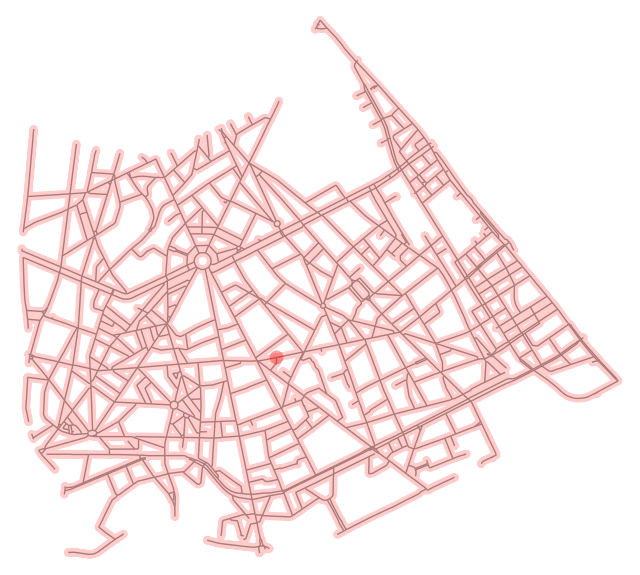

In [5]:
# List all edges of the extended graph including original edges and edges from minimal matching
single_edges = [(u, v) for u, v, k in graph.edges]
added_edges = get_shortest_paths(graph, matched_edges_with_weights)
edges = map_osmnx_edges2integers(graph, single_edges + added_edges)

# Finds the Eulerian path
network = Network(len(graph.nodes), edges, weighted=True)
eulerian_path = hierholzer(network)
converted_eulerian_path = convert_integer_path2osmnx_nodes(eulerian_path, graph.nodes())
double_edge_heap = get_double_edge_heap(org_graph)

# Finds the final path with edge IDs
final_path = convert_path(graph, converted_eulerian_path, double_edge_heap)

fig, ax = plot_graph_route(graph, final_path, route_linewidth=6, node_size=0, bgcolor="w", route_alpha=0.2, route_color="r")
#fig.savefig('maps/' + location + 'png')

In [6]:
def compute_vertices(path):
    x = []
    y = []
    for r in path:
        u, v, d = r
        data = graph.get_edge_data(u, v) or graph.get_edge_data(v, u)
        if d not in data:
            d = 0

        data = data[d]
        if "geometry" in data:
            # if geometry attribute exists, add all its coords to list
            xs, ys = data["geometry"].xy
            if data["from"] != u:
                xs.reverse()
                ys.reverse()
            x.extend(xs)
            y.extend(ys)
        else:
            # otherwise, the edge is a straight line from node to node
            x.extend((graph.nodes[u]["x"], graph.nodes[v]["x"]))
            y.extend((graph.nodes[u]["y"], graph.nodes[v]["y"]))
    return x,y


# This is suboptimal
def get_end_from_start(path, distance):
    
    covered_distance = 0
    n = len(path)
    step = 0
    last_loop_coordinate = None
    while step + 1 < n and covered_distance < distance:
        u,v,d = path[step]
        
        data = graph.get_edge_data(u, v) or graph.get_edge_data(v, u)
        if d not in data:
            d = 0
        xs, ys = [],[]
        data = data[d]
        if "geometry" in data:
            # if geometry attribute exists, add all its coords to list
            xs, ys = data["geometry"].xy
            if data["from"] != u:
                xs.reverse()
                ys.reverse()
        else:
            # otherwise, the edge is a straight line from node to node
            xs = graph.nodes[u]["x"], graph.nodes[v]["x"]
            ys = graph.nodes[u]["y"], graph.nodes[v]["y"]
            
        
        for i, _ in enumerate(xs):
            if i != 0: # If it's not the first element of the step, we can compute the distance with the previous vertex
                dist = geopy.distance.geodesic((xs[i-1],ys[i-1]),(xs[i], ys[i]))
                covered_distance += dist.meters
            elif last_loop_coordinate != None: # If it's the last element, we need to compute the distance with the last vertex of the last step
                dist = geopy.distance.geodesic(last_loop_coordinate,(xs[i], ys[i]))
                covered_distance += dist.meters
            last_loop_coordinate = (xs[i], ys[i])
        step +=1
    return step


def get_distance(path):
    
    # We start by computing the whole path for the path
    xs, ys = compute_vertices(path)
    s = 0
    for i, _ in enumerate(xs):
        if i != 0:
            dist = geopy.distance.geodesic((xs[i-1],ys[i-1]),(xs[i], ys[i]))
            s+= dist.meters
    return s
    

112


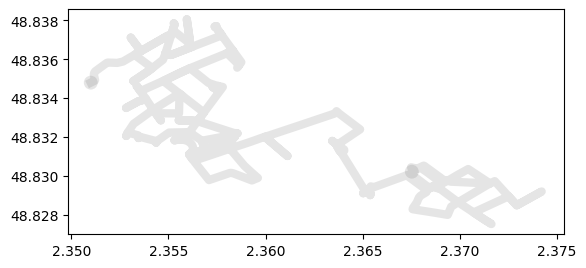

Distance totale 173448.18888623916
Distance parcourue 58494.49439298445


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation
plt.rcParams["animation.html"] = "jshtml"
import numpy as np

start = 452
distance = 10000

# First we start by computing the last vertex we can attaign

end = get_end_from_start(final_path[start: ], distance)
distance = get_distance(final_path[start: end + start])
total_distance = get_distance(final_path)
distance_jusque_la = get_distance(final_path[0 : start + end])
print(end)
fig, ax = plt.subplots()
ax.set_aspect("equal")
    
plot_graph_route(graph, final_path[max(start - int(end/2), 0): min(start + end, len(final_path))], route_linewidth=6, node_size=0, bgcolor="w", route_alpha=0.2, route_color="grey", ax = ax)
#plot_graph_route(graph, final_path[max(start, 0): min(start + end, len(final_path))], route_linewidth=6, node_size=0, bgcolor="w", route_alpha=0.2, route_color="grey", ax = ax)

def animate(i):
    plot_graph_route(graph, final_path[start:i+start + 1], route_linewidth=6, node_size=0, bgcolor="w", ax=ax, route_alpha=0.2)
    ax.set_title(location)    

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=(end))

print("Distance totale", total_distance)
print("Distance parcourue", distance_jusque_la)


In [8]:
print("We go from vertex", start, "to vertex", end + start)
print("Total distance", distance/1000, "km")
ani

We go from vertex 452 to vertex 564
Total distance 10.0758802888527 km


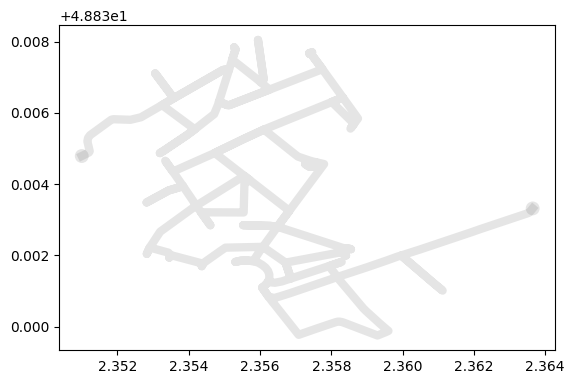

Started from 452
Ended at 564


In [9]:
# After each walk, I need to find the point where I stopped
i = end
fig, ax = plt.subplots()
ax.set_aspect("equal")
plot_graph_route(graph, final_path[start: start + i], route_linewidth=6, node_size=0, bgcolor="w", route_alpha=0.2, route_color="grey", ax = ax)
print("Started from", start)
print("Ended at", start + i)

In [20]:
import datetime

total_trip = {
    "5e Arrondissement":{
        "1":{
            "start": 0,
            "end": 108,
            "date":datetime.datetime(2023, 2, 1)
        },
        "2":{
            "start": 108,
            "end": 202,
            "date":datetime.datetime(2023, 2, 12)
        },
        "3":{
            "start": 202,
            "end": 297,
            "date":datetime.datetime(2023, 2, 13)
        },
        "4":{
            "start": 297,
            "end": 438,
            "date":datetime.datetime(2023, 3, 1)
        },
        "5":{
            "start": 438,
            "end": 600,
            "date":datetime.datetime(2023, 3, 2)
        },
        "6": {
            "start": 600,
            "end":743,
            "date":datetime.datetime(2023,3,13)
        }
    },
    "13e Arrondissement":{
        "1":{
            "start": 0,
            "end": 80,
            "date":datetime.datetime(2023, 4, 4)
        },
        "2":{
            "start": 80,
            "end": 188,
            "date":datetime.datetime(2023, 4, 15)
        },
        "3":{
            "start": 188,
            "end": 261,
            "date":datetime.datetime(2023, 4, 17)
        },
        "4":{
            "start": 261,
            "end": 343,
            "date":datetime.datetime(2023, 4, 17) # Not a bug, I did 2 this day
        },
        "5":{
            "start": 343,
            "end": 452,
            "date":datetime.datetime(2023, 4, 20) # Not a bug, I did 2 this day
        }
    }
}

2023-01-29 22:54:34 Begin plotting the graph...
2023-01-29 22:54:34 Created edges GeoDataFrame from graph
2023-01-29 22:54:34 Finished plotting the graph


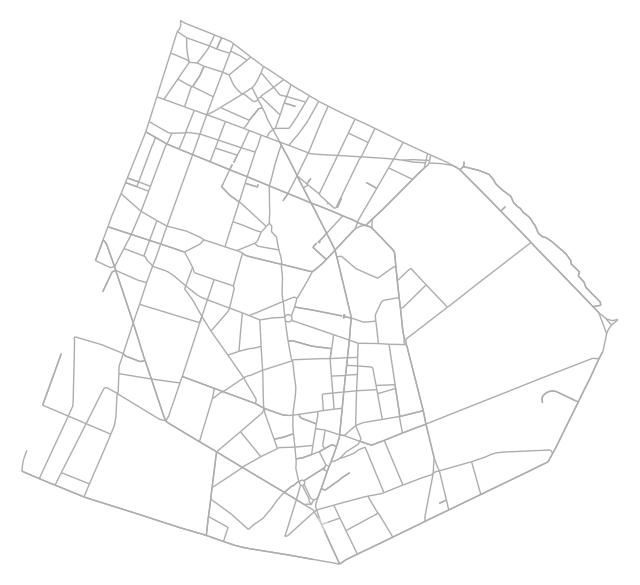

In [64]:
fig, ax = plot_graph_route(org_graph, final_path, route_linewidth=6, node_size=0, bgcolor="w", route_alpha=0.2, route_color="w")

In [8]:
%matplotlib inline
import os

import geopandas as gpd
import matplotlib.pyplot as plt

import mplleaflet

![](docs/everystreet_grange.gif)